In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import numpy as np


In [2]:



folder_path = "C:/Users/Miranda Córdova/Desktop/deep learning/tuberculosis"

# Initialize an empty list to store DataFrames for each file
dfs = []

# Loop through each file in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a .txt file
    if file_name.endswith(".txt"):
        # Create the full file path
        file_path = os.path.join(folder_path, file_name)

        # Open the file and apply the provided code
        with open(file_path, "r") as file:
            # Filter out unwanted lines
            file_content = "\n".join(line for line in file if "</div" not in line and "<div" not in line and "<pre" not in line)

        # Split the content into sequences and labels
        entries = file_content.split(">")
        labels = []
        sequences = []

        # Process each entry
        for entry in entries[1:]:
            entry_parts = entry.split("\n", 1)
            labels.append(entry_parts[0])
            sequences.append(entry_parts[1].replace("\n", "") if len(entry_parts) > 1 else "")

        # Count the number of letters in each sequence
        letter_counts = [len(sequence) for sequence in sequences]

        # Create a DataFrame for the current file
        df = pd.DataFrame({
            'NCBI_title': labels,
            'Sequence': sequences,
            'Letter_Count': letter_counts,
            'Label': file_name[:-4]  # Remove the last 4 characters (.txt)
        })

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)

# Print the final DataFrame
print(final_df)


                                           NCBI_title  \
0   CP001641.1 Mycobacterium tuberculosis CCDC5079...   
1   CP001642.1 Mycobacterium tuberculosis CCDC5180...   
2   CP001658.1 Mycobacterium tuberculosis KZN 1435...   
3   CP001664.1 Mycobacterium tuberculosis str. Haa...   
4   CP002884.1 Mycobacterium tuberculosis CCDC5079...   
5   CP002992.1 Mycobacterium tuberculosis CTRI-2, ...   
6   NC_000962.3 Mycobacterium tuberculosis H37Rv, ...   
7   NC_009525.1 Mycobacterium tuberculosis H37Ra, ...   
8   NC_009565.1 Mycobacterium tuberculosis F11, co...   
9   NC_012943.1 Mycobacterium tuberculosis KZN 143...   
10  NC_018078.1 Mycobacterium tuberculosis KZN 605...   
11  NC_021251.1 Mycobacterium tuberculosis CCDC507...   

                                             Sequence  Letter_Count  \
0   TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4396712   
1   TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4403881   
2   ATTTGTGGATAGCCATGTGGACAGTTCACCTGCCCACAACA

In [3]:
# Function to calculate GC ratio
def calculate_gc_ratio(sequence):
    nG = sequence.count('G')
    nC = sequence.count('C')
    nA = sequence.count('A')
    nT = sequence.count('T')

    # Avoid division by zero
    if nA + nG + nC + nT == 0:
        return 0

    gc_ratio = (nG + nC) / (nA + nG + nC + nT)
    return gc_ratio

# Apply the function to create a new 'GC_ratio' column
final_df['GC_mean'] = final_df['Sequence'].apply(calculate_gc_ratio)

In [4]:
def GC_encode(short_read_line):
    mapping = {'G': -1, 'A': -1, 'T': 1, 'C': 1, 'N': 0}
    return [mapping.get(base, 0) for base in short_read_line]

# Apply GC_encode to the 'Sequence' column
final_df['GC_Encoded'] = final_df['Sequence'].apply(GC_encode)



Aplicar wavelet Haar sobre representacion matemática de las bases no es suficiente, 137883 en level_5_approximation_encoded

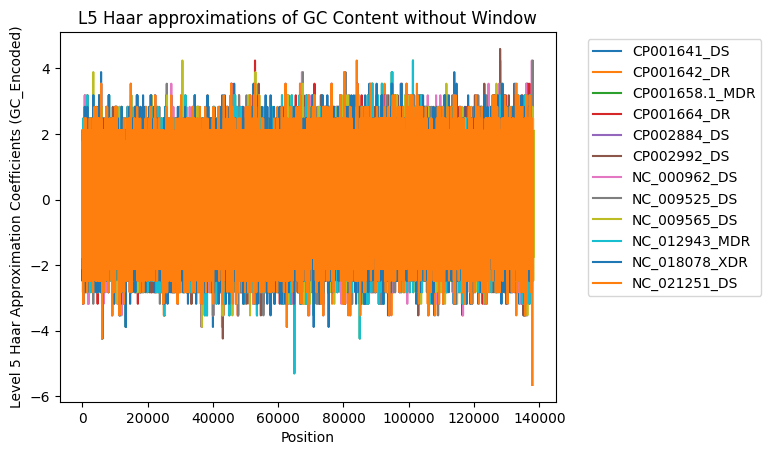

In [8]:
final_df['haar_5_GC_Encoded'] = final_df['GC_Encoded'].apply(lambda x: pywt.wavedec(x, 'haar', level=5))

for index, row in final_df.iterrows():
    level_5_approximation_encoded = row['haar_5_GC_Encoded'][0]  # Index 0 corresponds to the approximation coefficients
    position_values = range(0, len(level_5_approximation_encoded))
    label_value = row['Label']
    plt.plot(position_values, level_5_approximation_encoded, label=f"{label_value}")

plt.title('L5 Haar approximations of GC Content without Window')
plt.xlabel('Position')
plt.ylabel('Level 5 Haar Approximation Coefficients (GC_Encoded)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


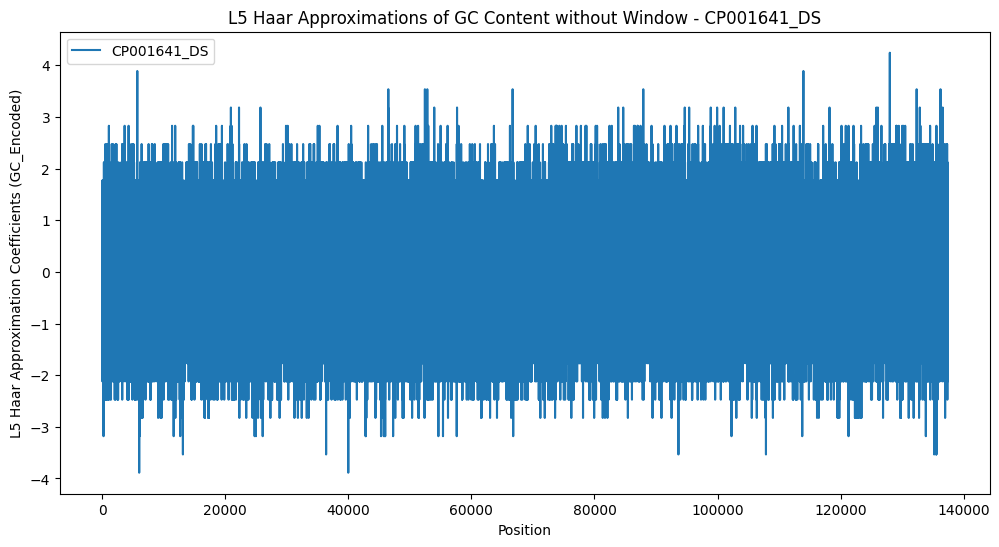

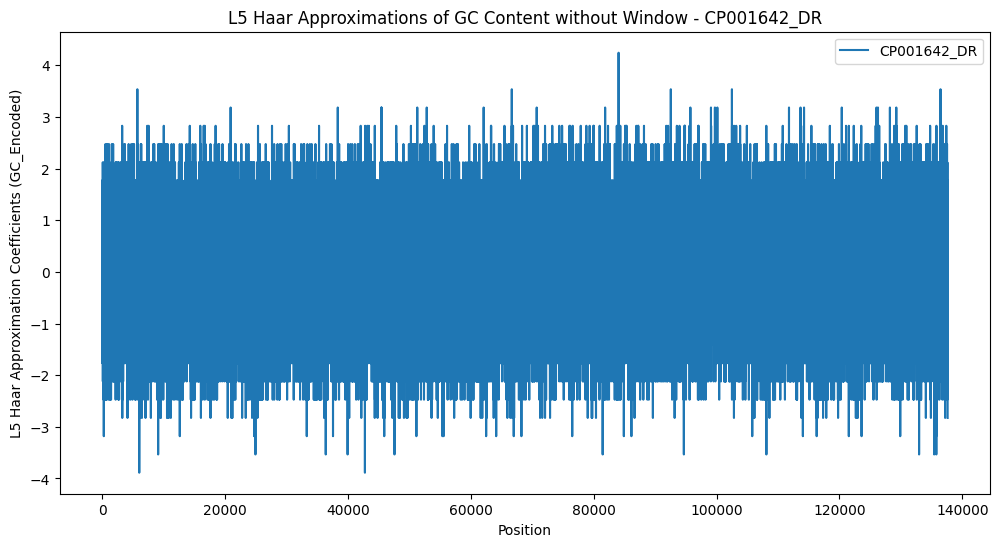

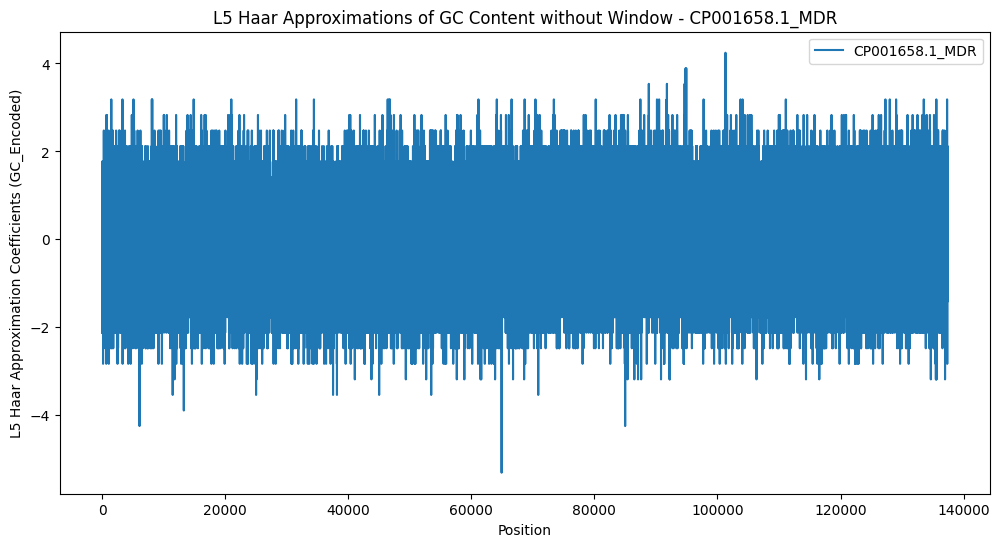

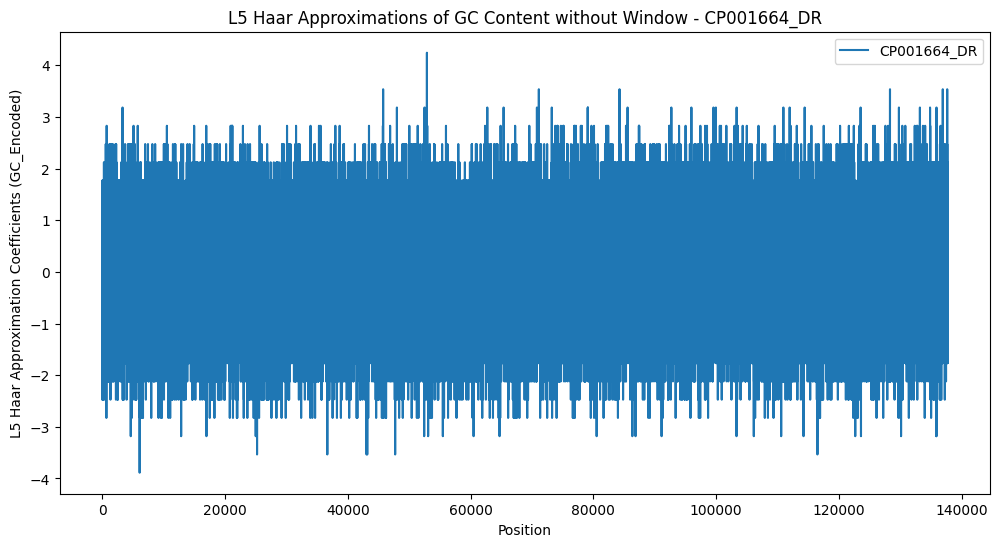

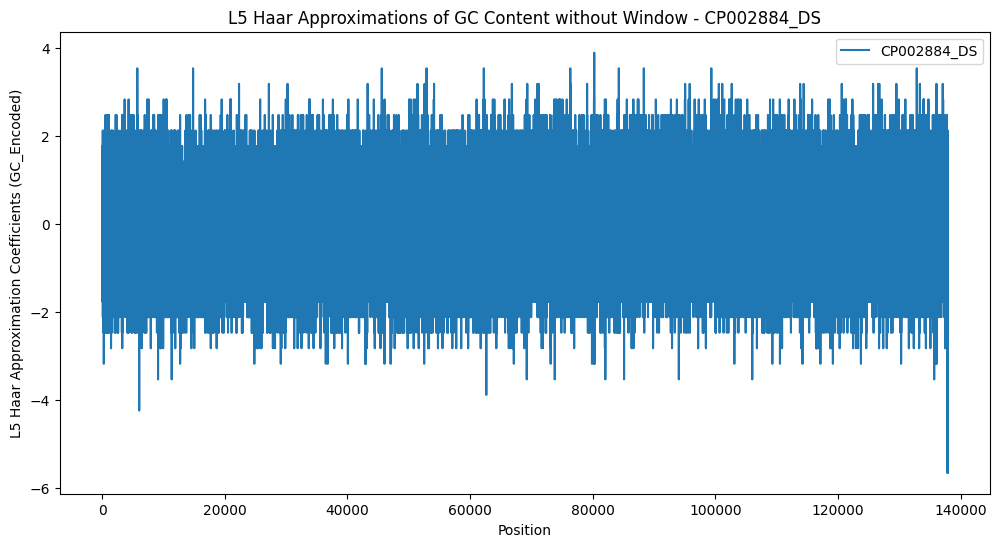

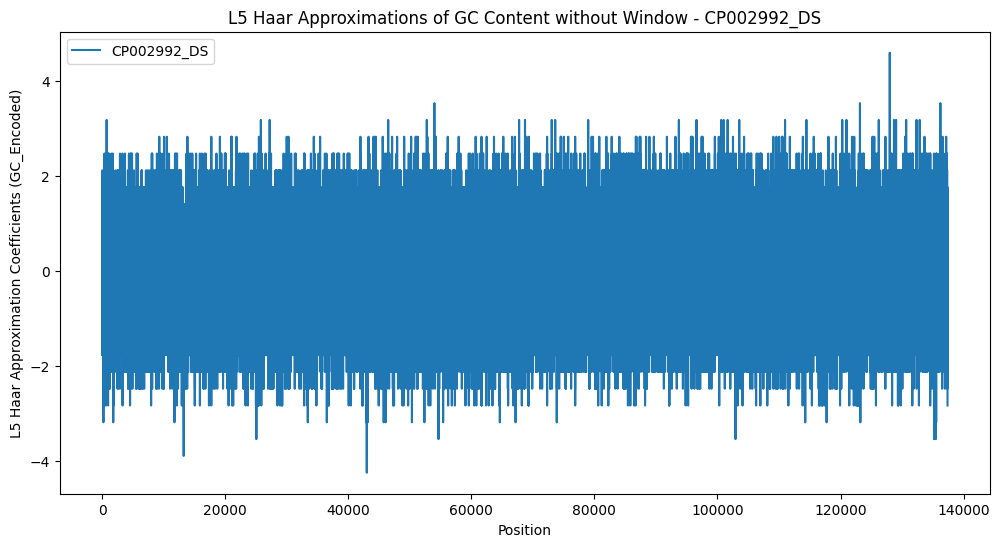

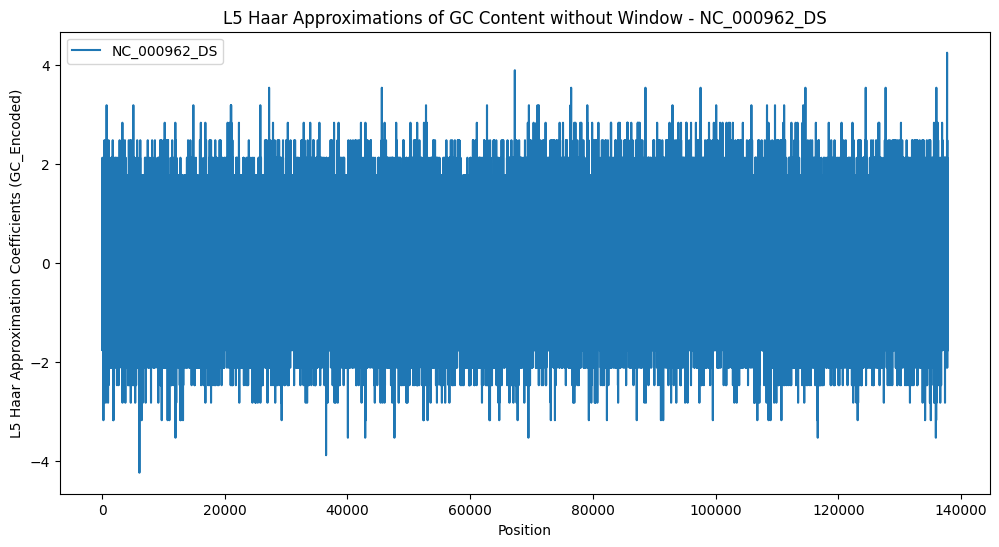

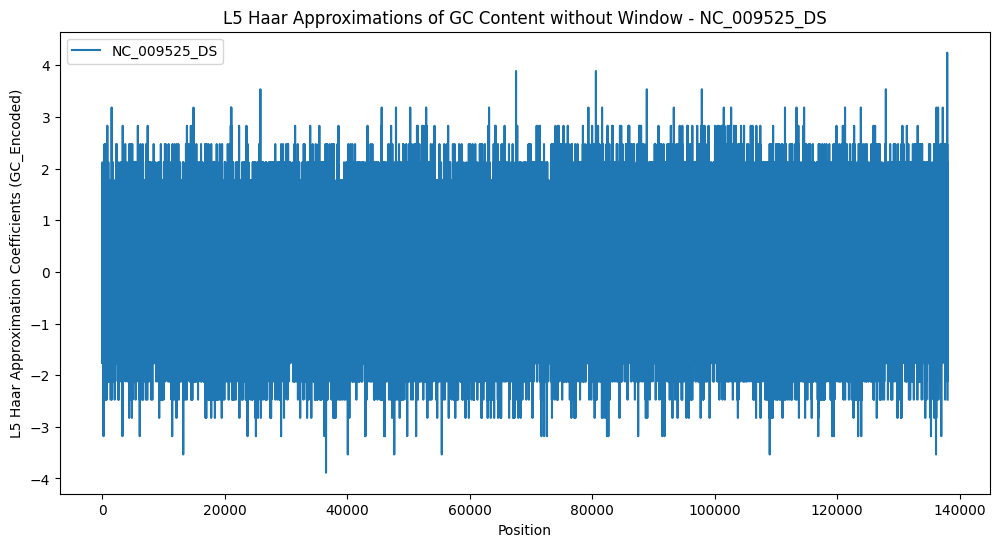

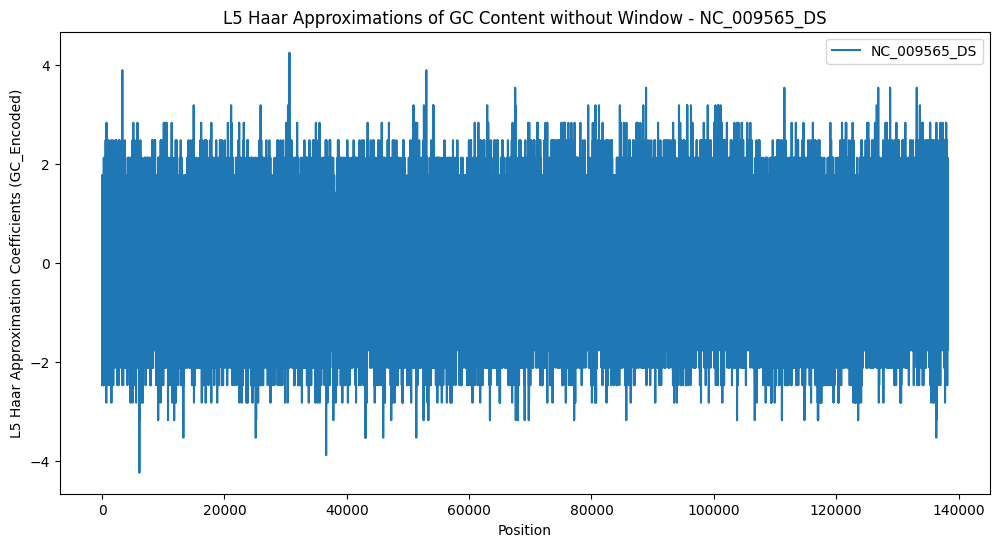

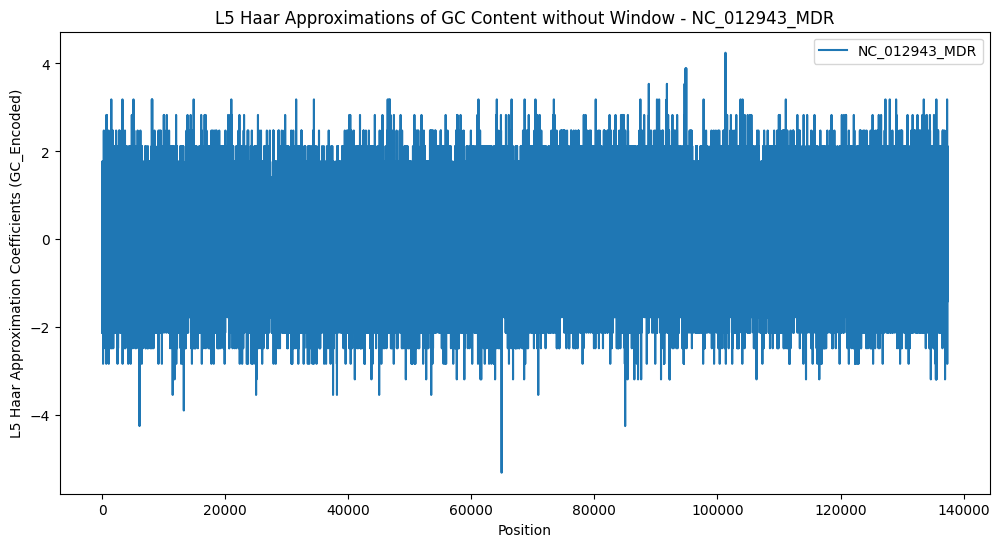

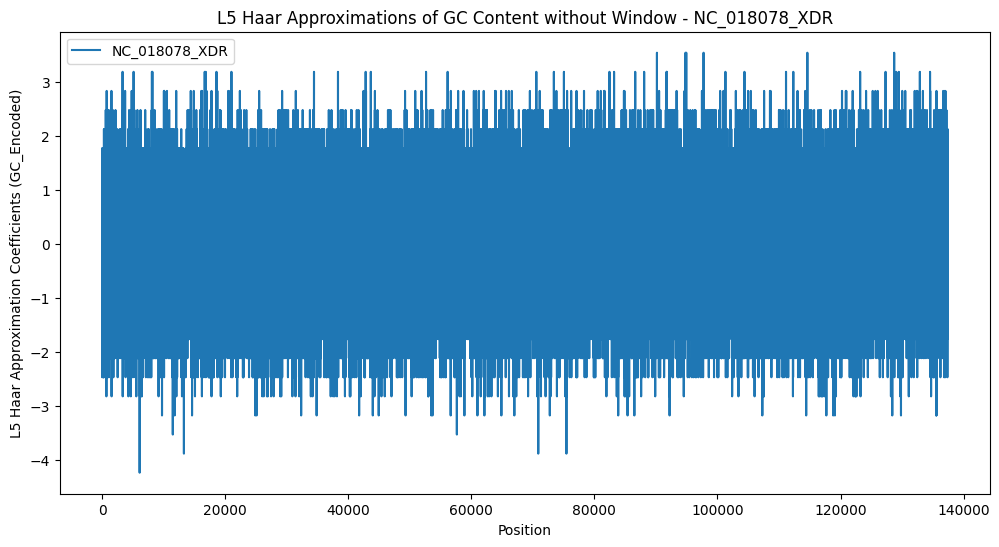

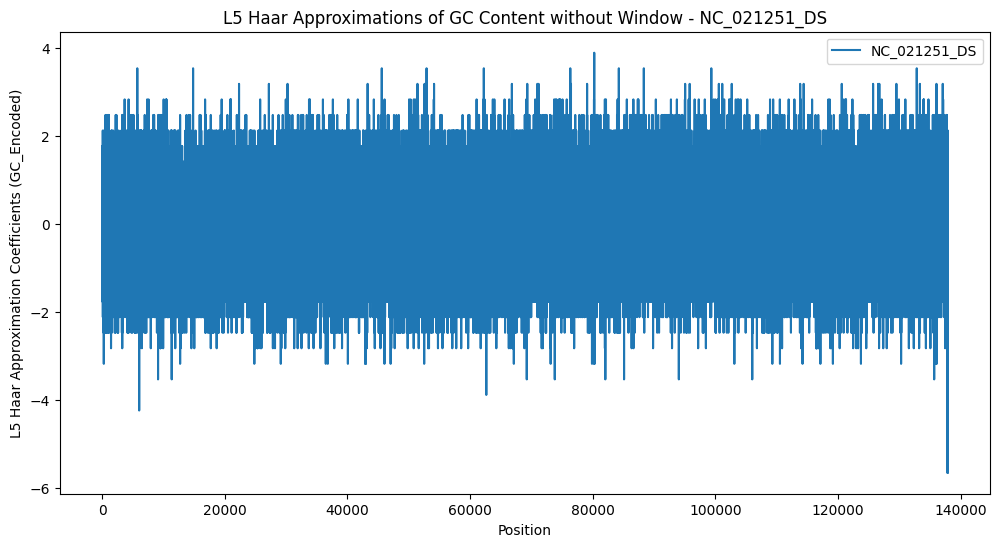

In [9]:


for index, row in final_df.iterrows():
    plt.figure(figsize=(12, 6))  # Create a new figure for each row
    level_5_approximation_encoded = row['haar_5_GC_Encoded'][0]  # Index 0 corresponds to the approximation coefficients
    position_values = range(0, len(level_5_approximation_encoded))
    label_value = row['Label']
    plt.plot(position_values, level_5_approximation_encoded, label=f"{label_value}")

    plt.title(f'L5 Haar Approximations of GC Content without Window - {label_value}')
    plt.xlabel('Position')
    plt.ylabel('L5 Haar Approximation Coefficients (GC_Encoded)')
    plt.legend()
    
    plt.show()  # Display the current plot

In [10]:
len(level_5_approximation_encoded)

137883

Usar la ventana deslizante tampoco es suficiente 

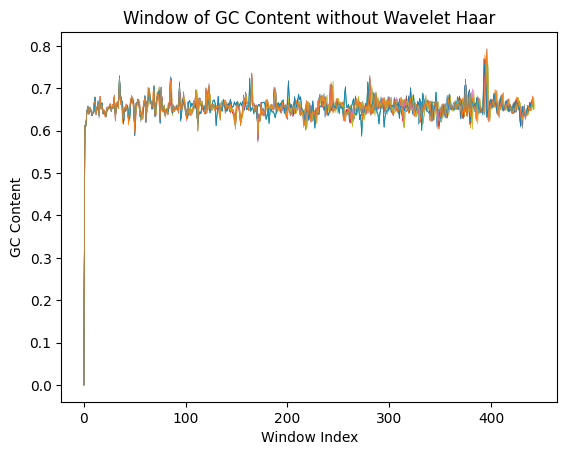

In [14]:

def sliding_window_gc(sequence, window_size=10000):
    gc_contents = []

    # Calculate GC content for the first 10000 elements
    first_window = sequence[:window_size]
    gc_contents.append(calculate_gc_ratio(first_window))

    sequence_length = len(sequence)

    # Calculate GC content using sliding window for the rest of the sequence
    for i in range(1, sequence_length - window_size + 1, window_size):
        window_sequence = sequence[i:i + window_size]
        gc_content = calculate_gc_ratio(window_sequence)
        gc_contents.append(gc_content)

    return gc_contents

# Calculate GC content using sliding window for each row in the DataFrame
final_df['GC_Content_Windowed'] = final_df['Sequence'].apply(lambda x: sliding_window_gc(x, window_size=10000))

# Plot the results for each row
for index, row in final_df.iterrows():
    label_value = row['Label']  # Get the 'Label' value for the current row
    plt.plot([0] + row['GC_Content_Windowed'], label=label_value,linewidth=0.5)

plt.title('Window of GC Content without Wavelet Haar')
plt.xlabel('Window Index')
plt.ylabel('GC Content')

plt.show()

Indistinguible las secuencias solo con WT

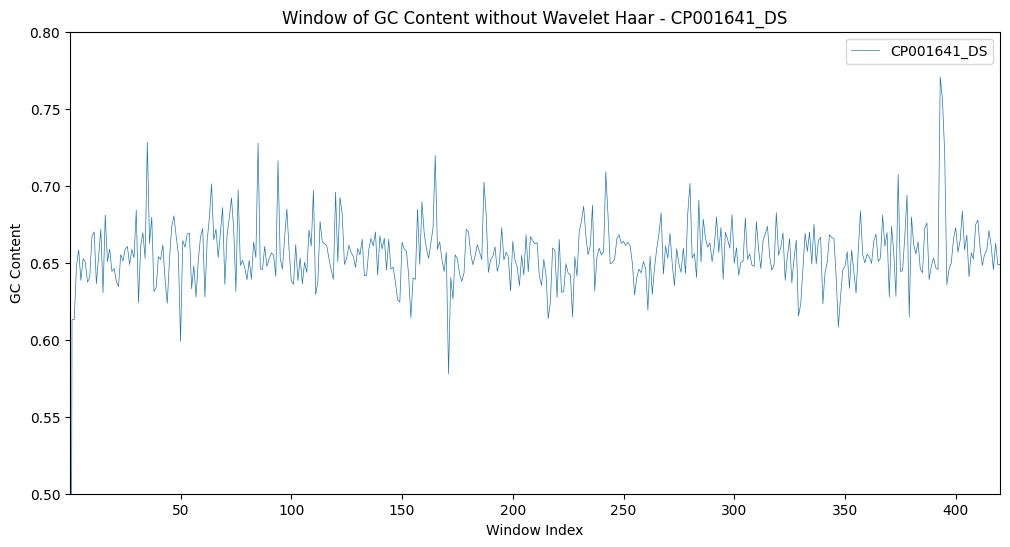

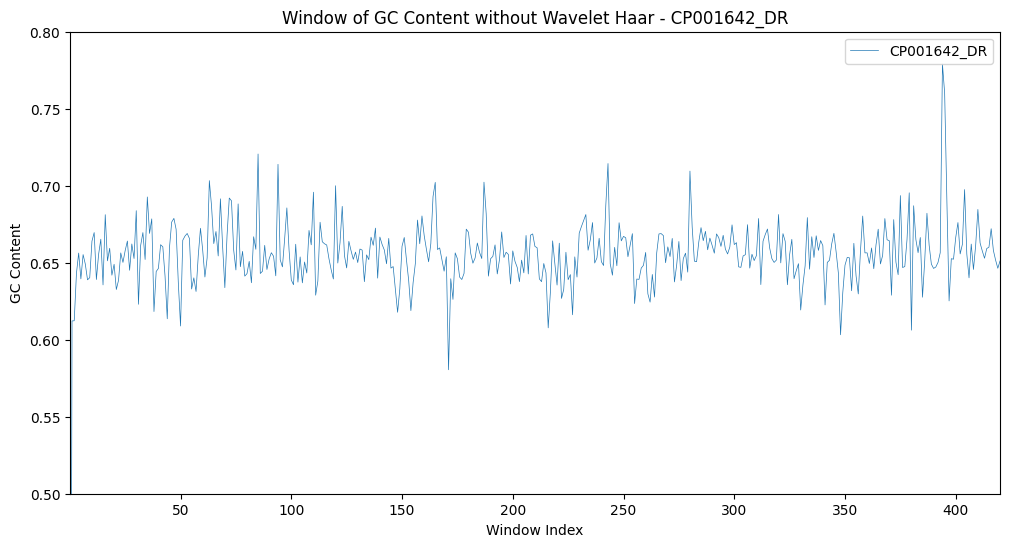

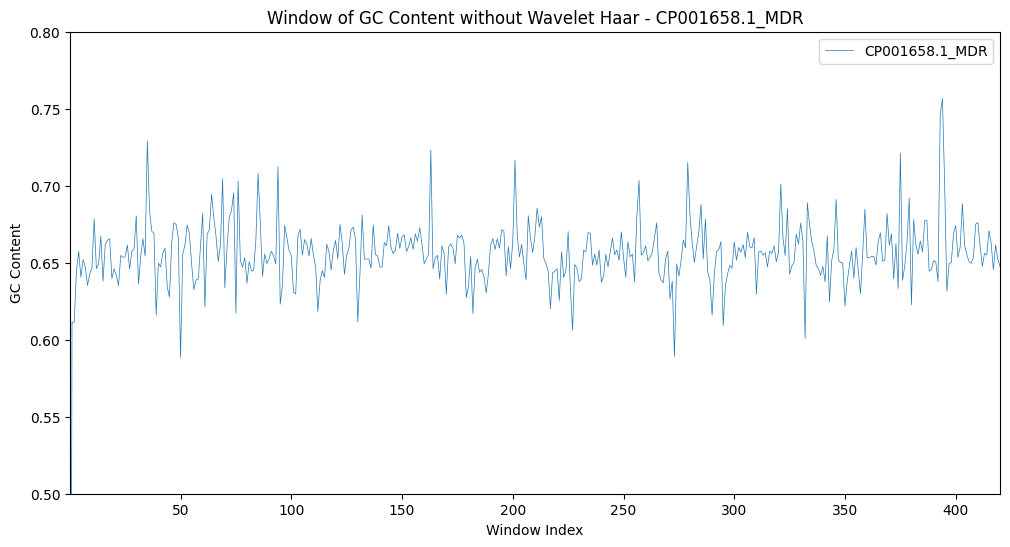

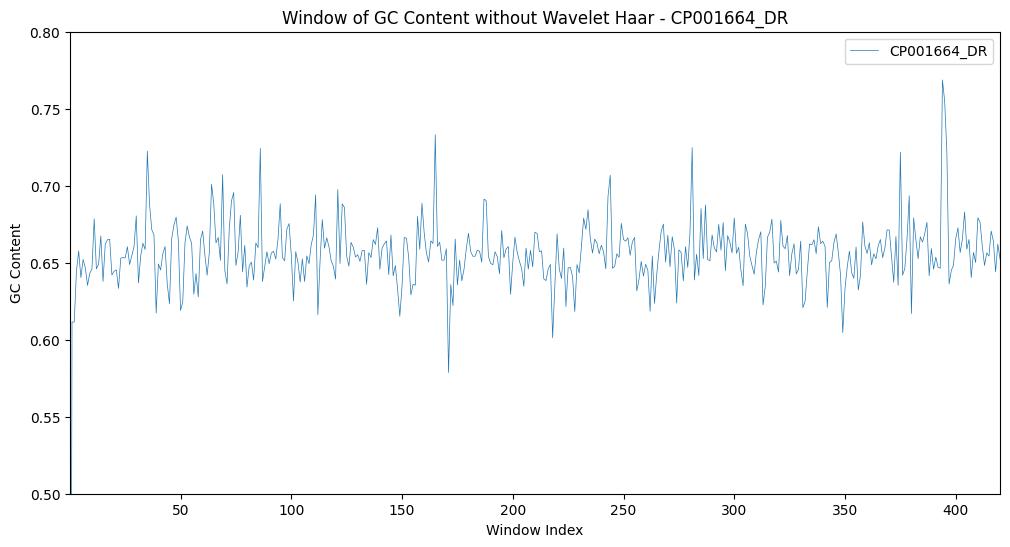

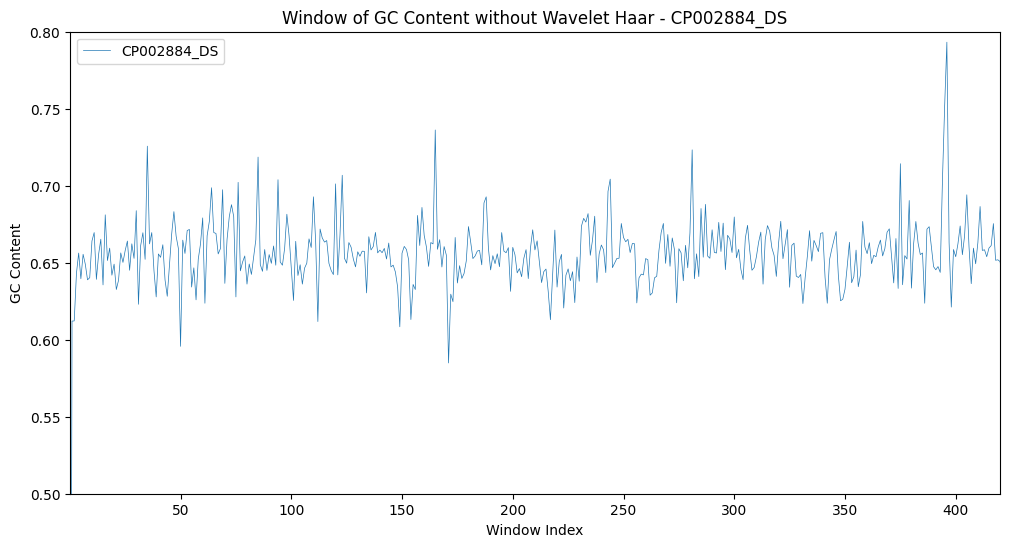

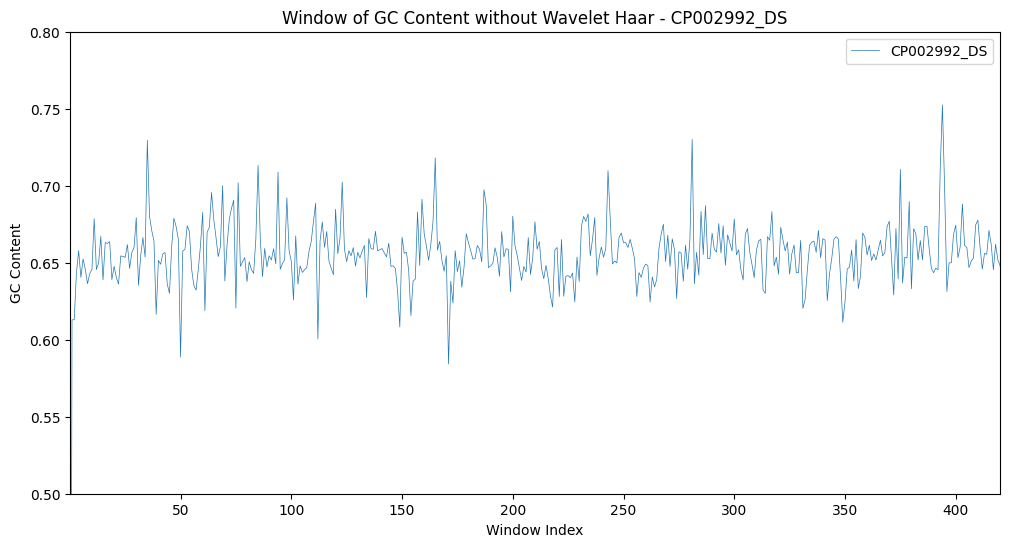

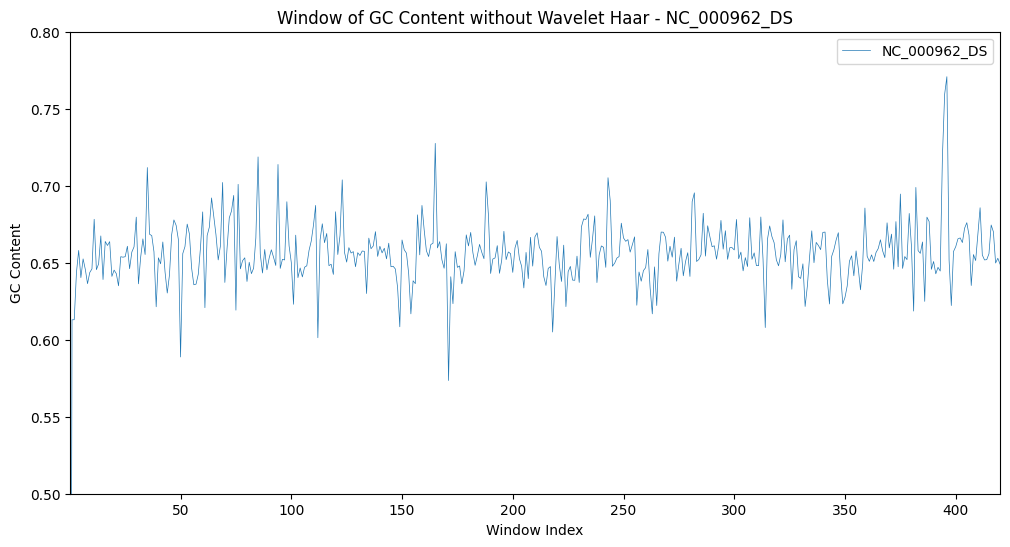

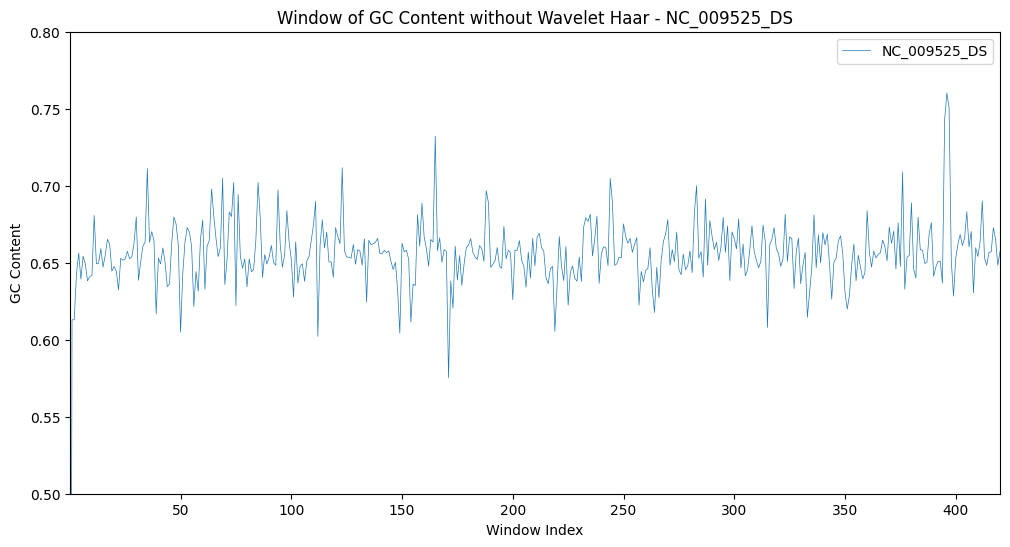

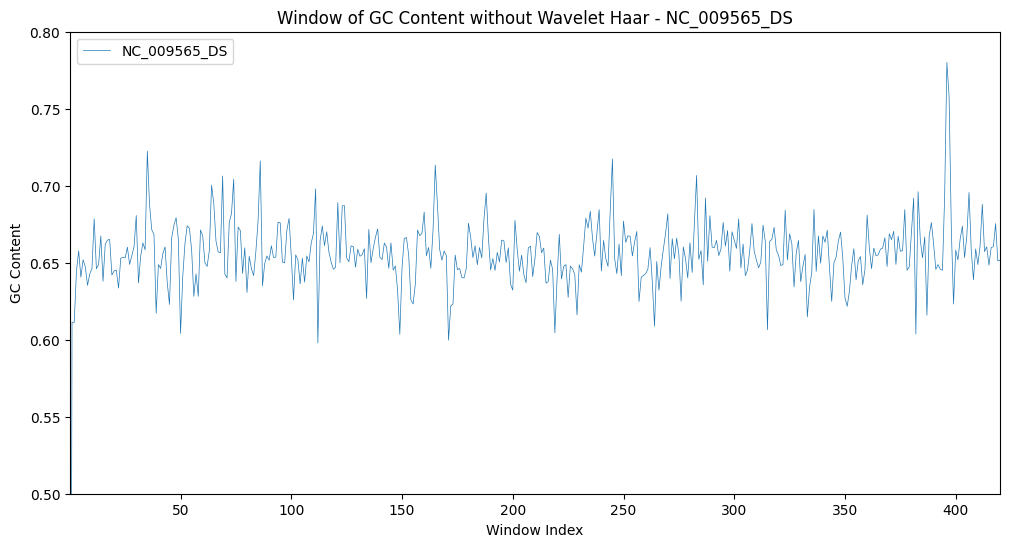

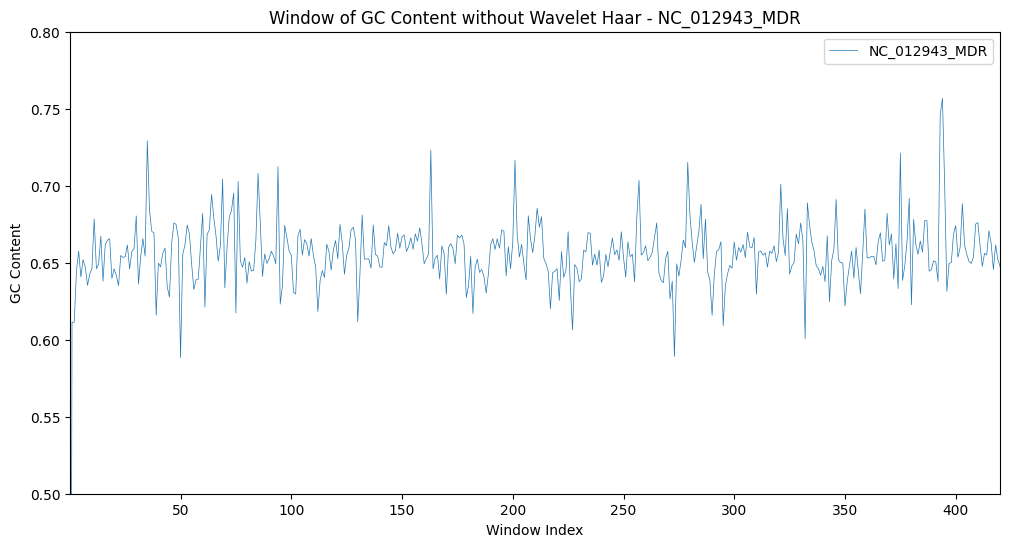

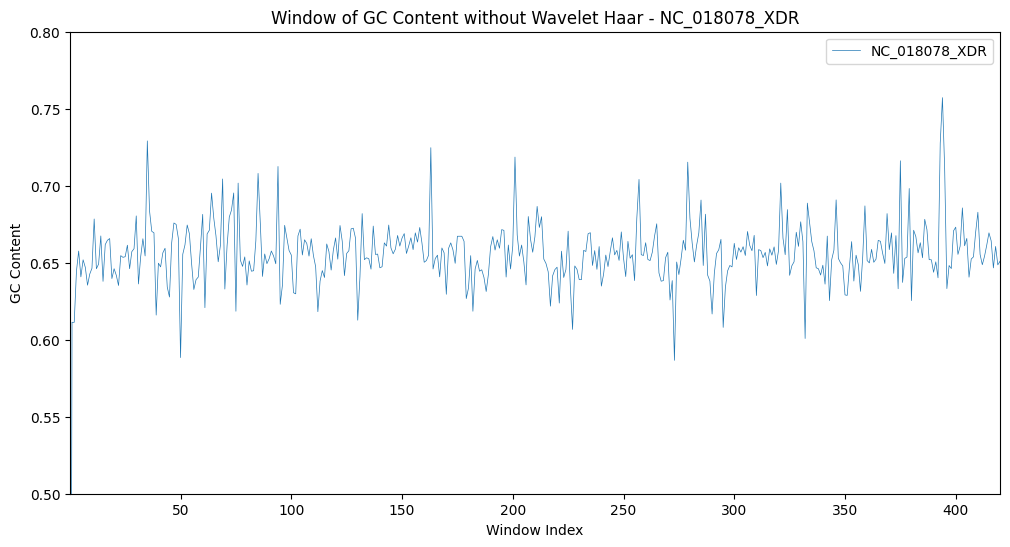

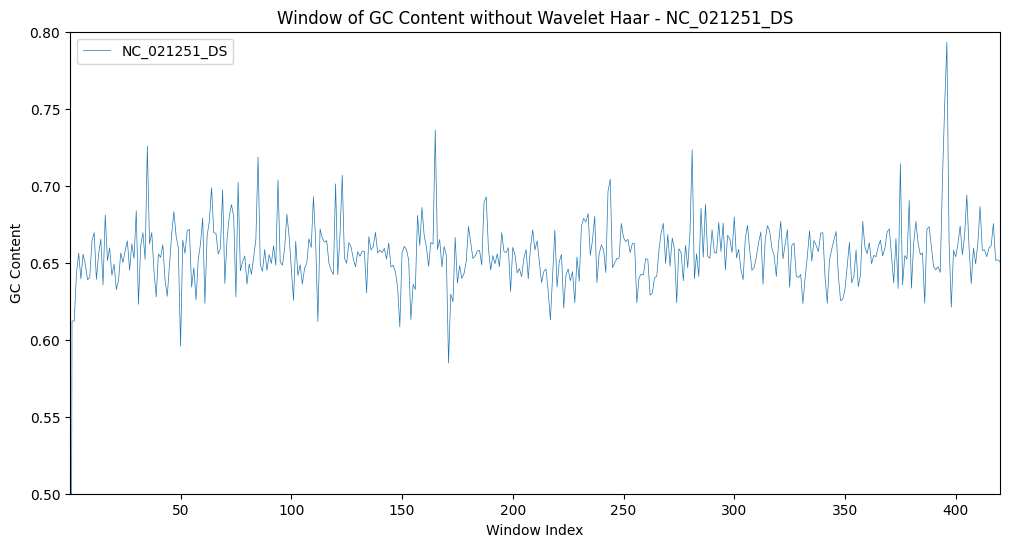

In [15]:
for index, row in final_df.iterrows():
    plt.figure(figsize=(12, 6))  
    label_value = row['Label'] 
    plt.plot([0] + row['GC_Content_Windowed'], label=label_value, linewidth=0.5)
    
    plt.title(f'Window of GC Content without Wavelet Haar - {label_value}')
    plt.xlabel('Window Index')
    plt.ylabel('GC Content')
    plt.legend()
    
    plt.ylim(0.5, 0.8)  
    plt.xlim(0.1, 420) 
    plt.show()  # Display the current plot

In [121]:
len(final_df['GC_Content_Windowed'][0])

440

Combinar ambas se inicia distinguir valores tendencias

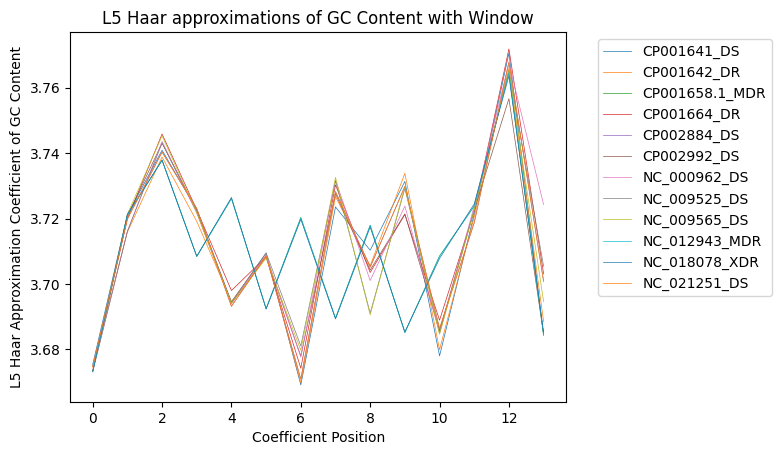

In [16]:


# Apply Haar wavelet transformation to the GC content of each row
final_df['Haar_Approximation_GC_Encoded'] = final_df['GC_Content_Windowed'].apply(lambda x: pywt.wavedec(x, 'haar', level=5)[0])

# Plot the approximation coefficients for each row
for index, row in final_df.iterrows():
    label_value = row['Label'] 
    plt.plot([i for i in range(len(row['Haar_Approximation_GC_Encoded']))], row['Haar_Approximation_GC_Encoded'], label=label_value,linewidth=0.5)

plt.title('L5 Haar approximations of GC Content with Window')

plt.xlabel('Coefficient Position')
plt.ylabel('L5 Haar Approximation Coefficient of GC Content')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


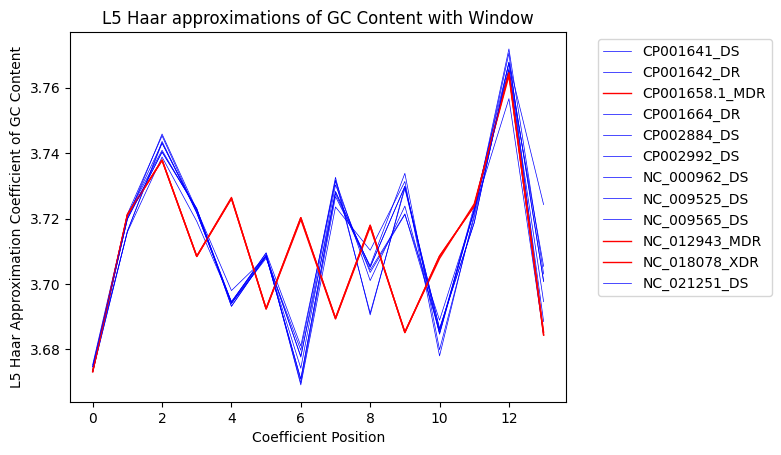

In [23]:
# Apply Haar wavelet transformation to the GC content of each row
final_df['Haar_Approximation_GC_Encoded'] = final_df['GC_Content_Windowed'].apply(lambda x: pywt.wavedec(x, 'haar', level=5)[0])

# Plot the approximation coefficients for each row
for index, row in final_df.iterrows():
    label_value = row['Label'] 
    position_values = range(len(row['Haar_Approximation_GC_Encoded']))
    
    # Check if the current row is one of the specified indices
    if index in [2, 9, 10]:
        plt.plot(position_values, row['Haar_Approximation_GC_Encoded'], label=label_value, linewidth=1, color='red')
    else:
        plt.plot(position_values, row['Haar_Approximation_GC_Encoded'], label=label_value, linewidth=0.5, color='blue')

plt.title('L5 Haar approximations of GC Content with Window')
plt.xlabel('Coefficient Position')
plt.ylabel('L5 Haar Approximation Coefficient of GC Content')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


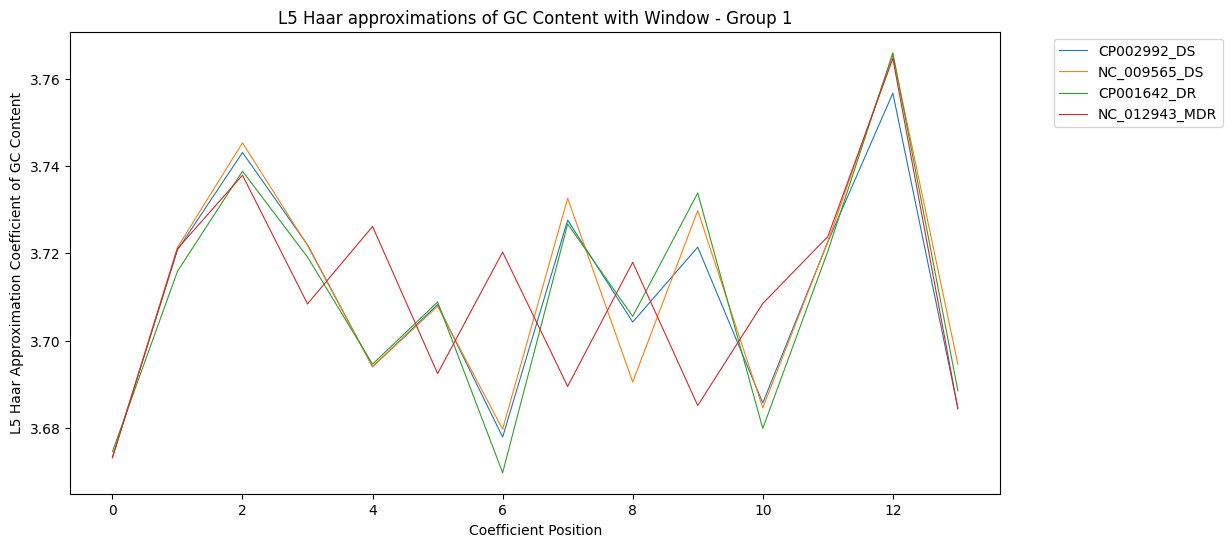

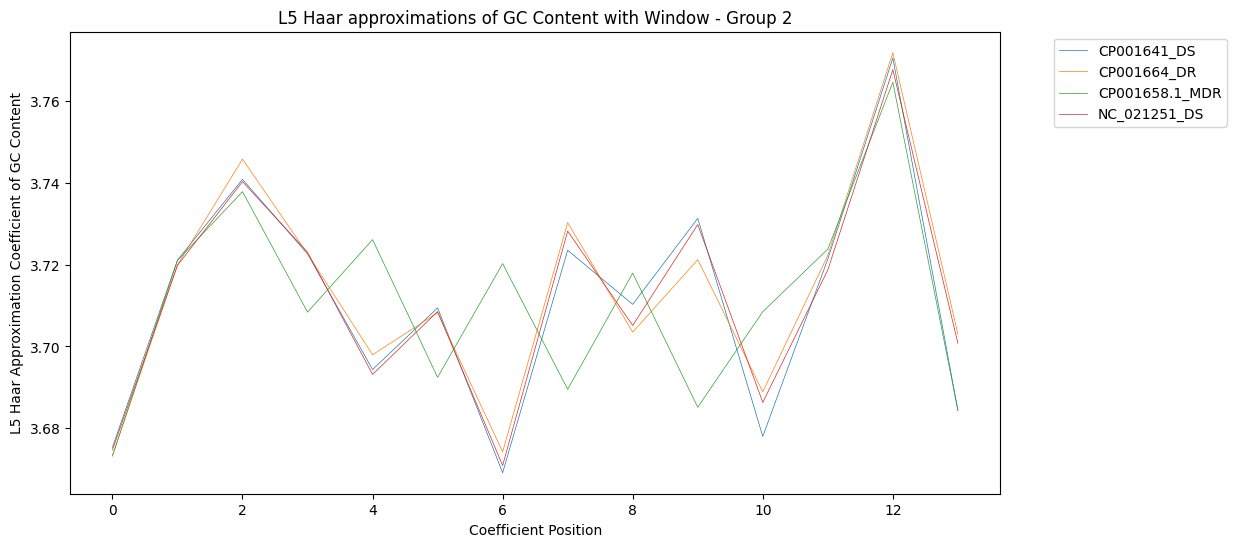

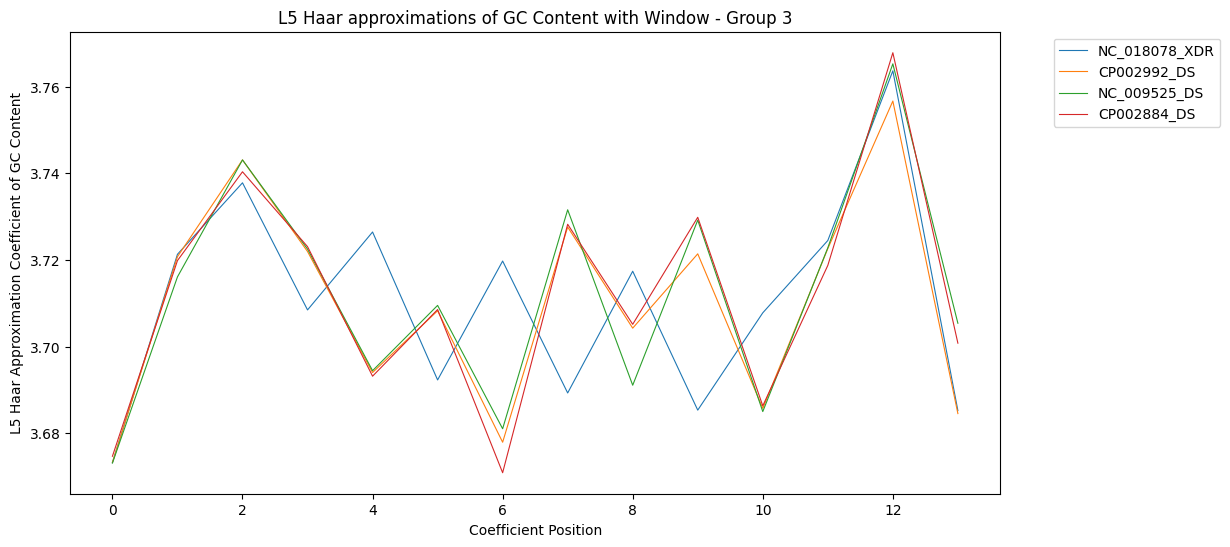

In [18]:
# Separate rows into different groups
group1_indices = [5,8,1,9]#6,9,2,10] 
group2_indices = [0,3,2,11]#1,4,3,12] 
group3_indices =[10,5,7,4]#11,6,8,5]

plt.figure(figsize=(12, 6))
for index in group1_indices:
    label_value = final_df.loc[index, 'Label']
    plt.plot([i for i in range(len(final_df.loc[index, 'Haar_Approximation_GC_Encoded']))],
             final_df.loc[index, 'Haar_Approximation_GC_Encoded'],
             label=label_value, linewidth=0.8)

plt.title('L5 Haar approximations of GC Content with Window - Group 1')
plt.xlabel('Coefficient Position')
plt.ylabel('L5 Haar Approximation Coefficient of GC Content')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the approximation coefficients for the second group
plt.figure(figsize=(12, 6))
for index in group2_indices:
    label_value = final_df.loc[index, 'Label']
    plt.plot([i for i in range(len(final_df.loc[index, 'Haar_Approximation_GC_Encoded']))],
             final_df.loc[index, 'Haar_Approximation_GC_Encoded'],
             label=label_value, linewidth=0.5)

plt.title('L5 Haar approximations of GC Content with Window - Group 2')
plt.xlabel('Coefficient Position')
plt.ylabel('L5 Haar Approximation Coefficient of GC Content')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
for index in group3_indices:
    label_value = final_df.loc[index, 'Label']
    plt.plot([i for i in range(len(final_df.loc[index, 'Haar_Approximation_GC_Encoded']))],
             final_df.loc[index, 'Haar_Approximation_GC_Encoded'],
             label=label_value, linewidth=0.8)

plt.title('L5 Haar approximations of GC Content with Window - Group 3')
plt.xlabel('Coefficient Position')
plt.ylabel('L5 Haar Approximation Coefficient of GC Content')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

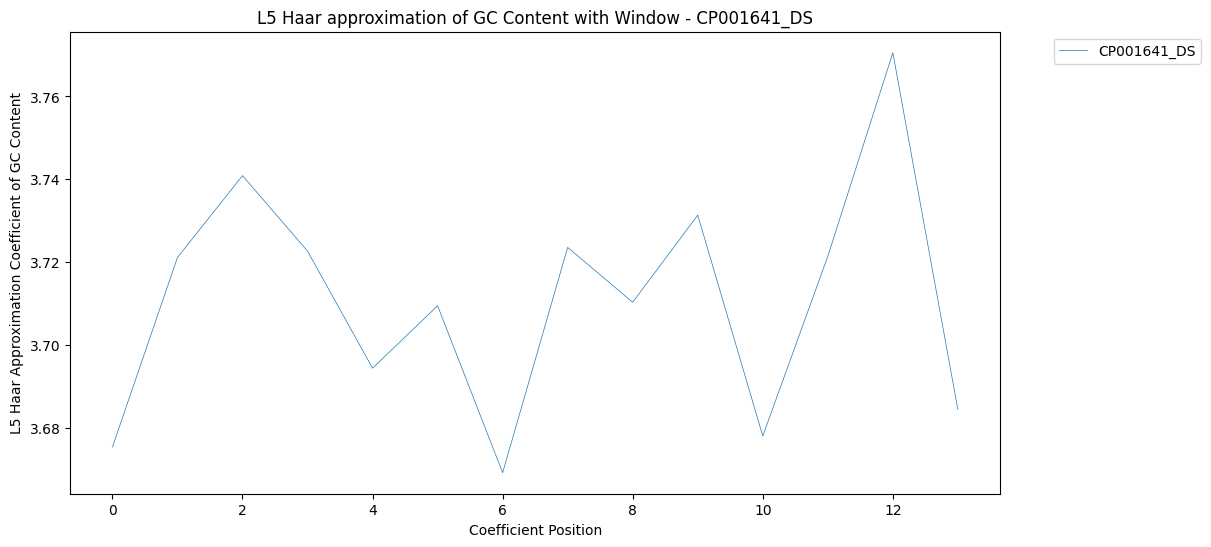

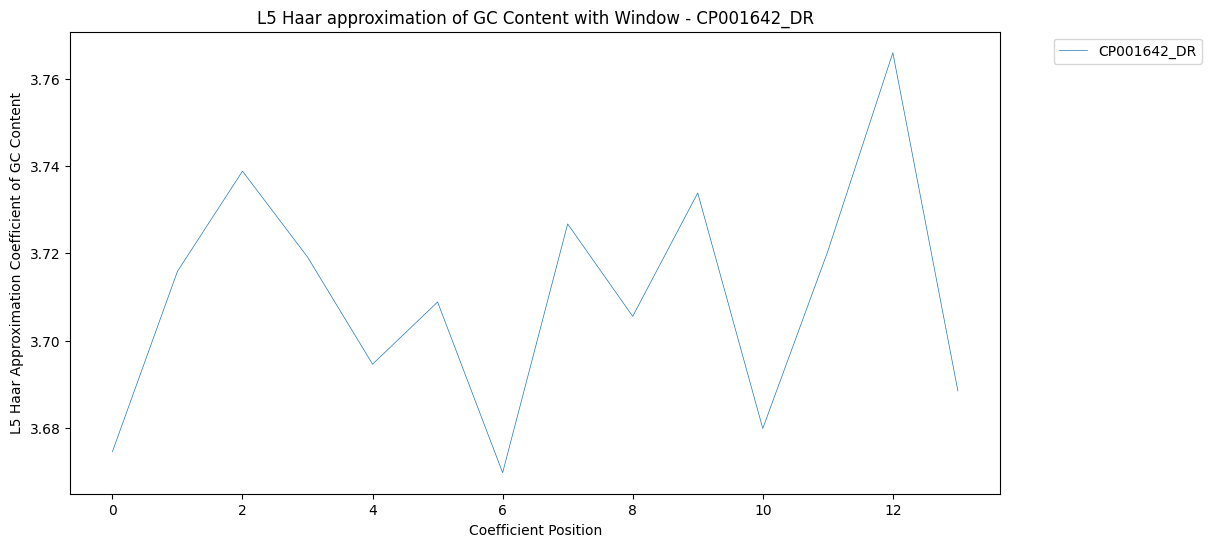

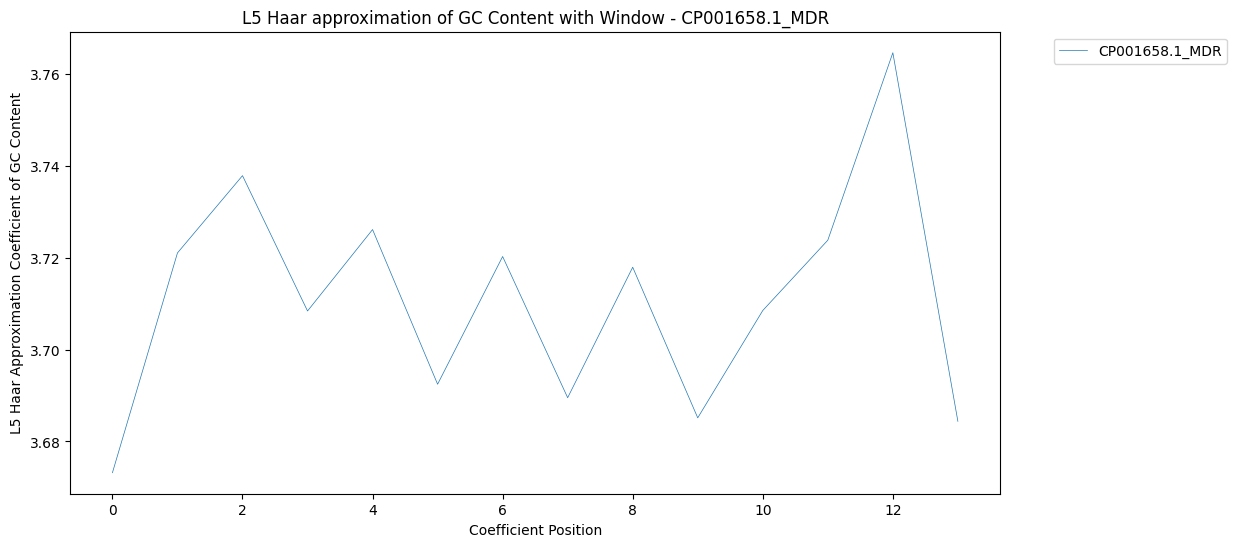

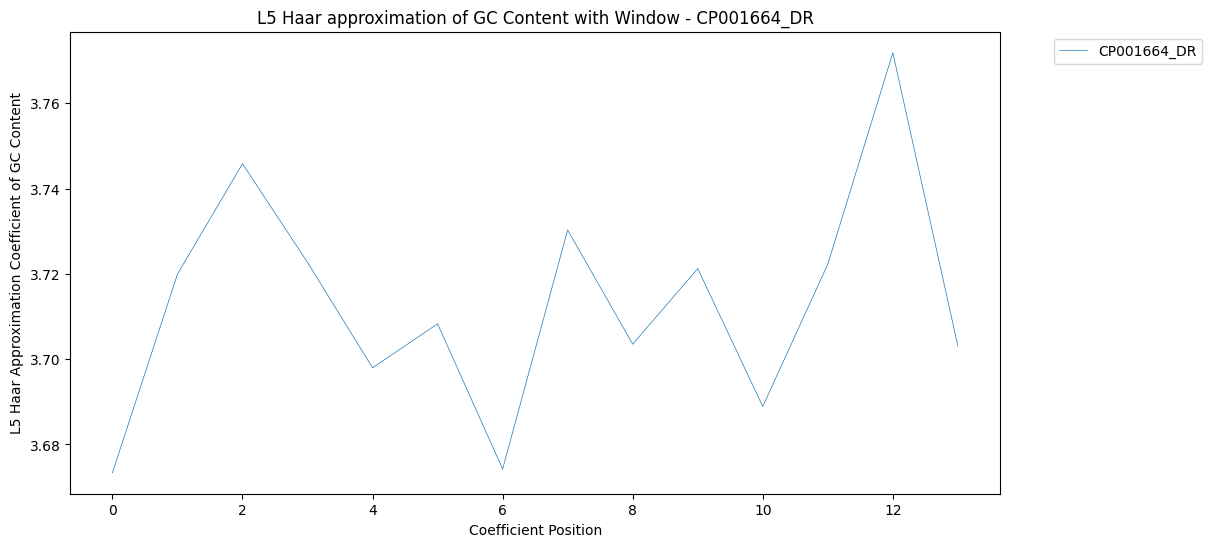

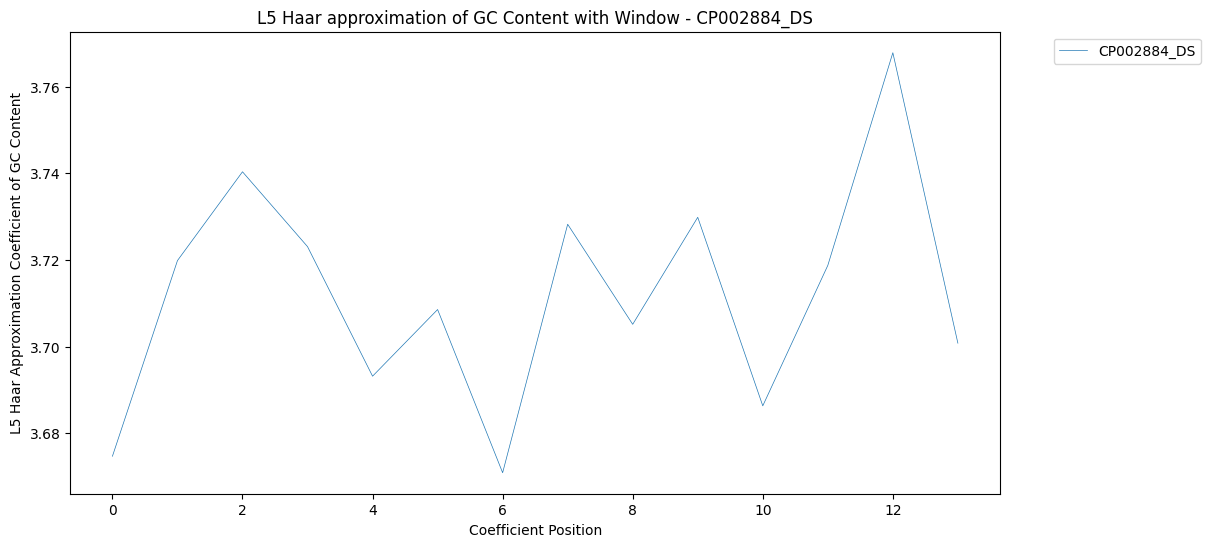

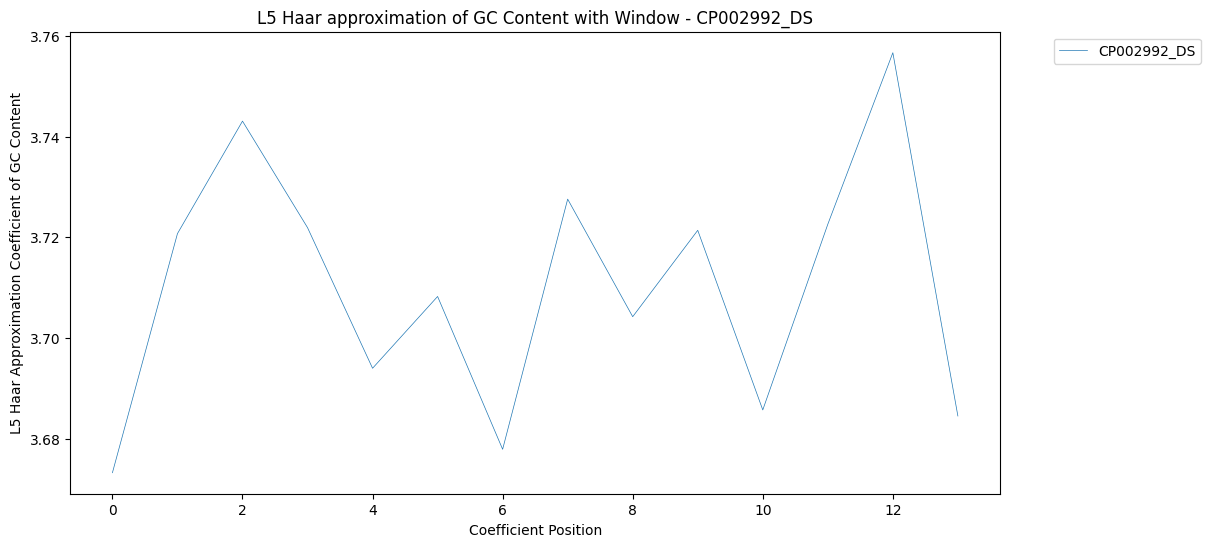

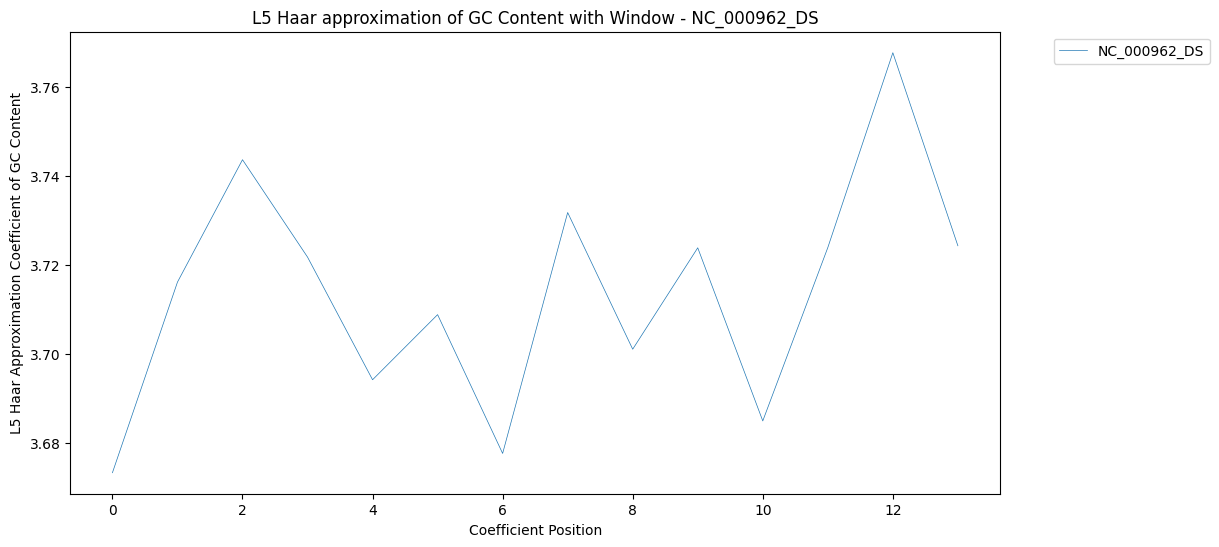

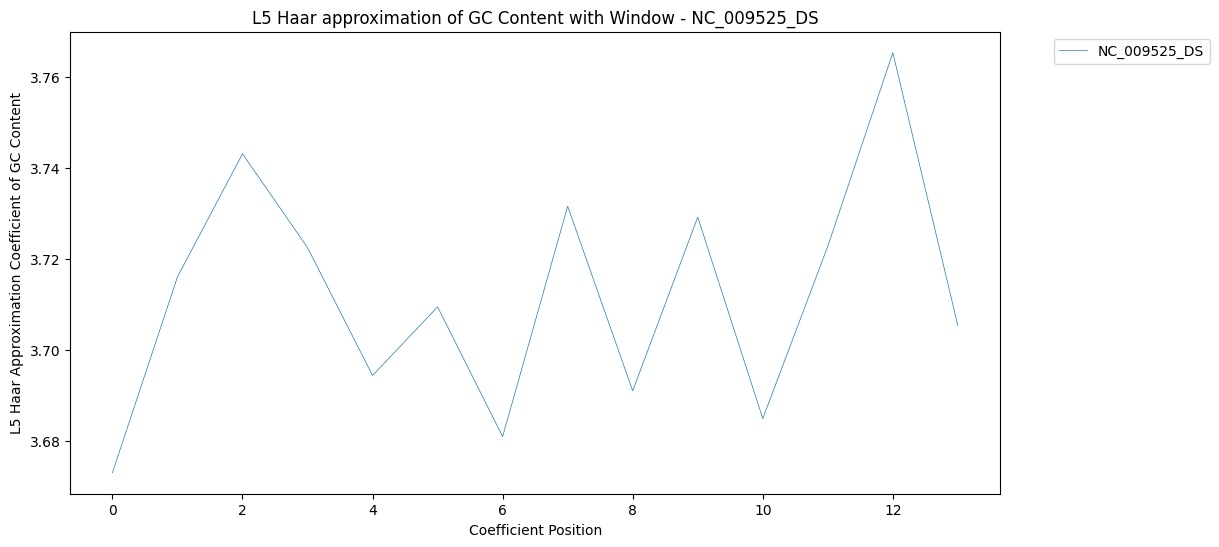

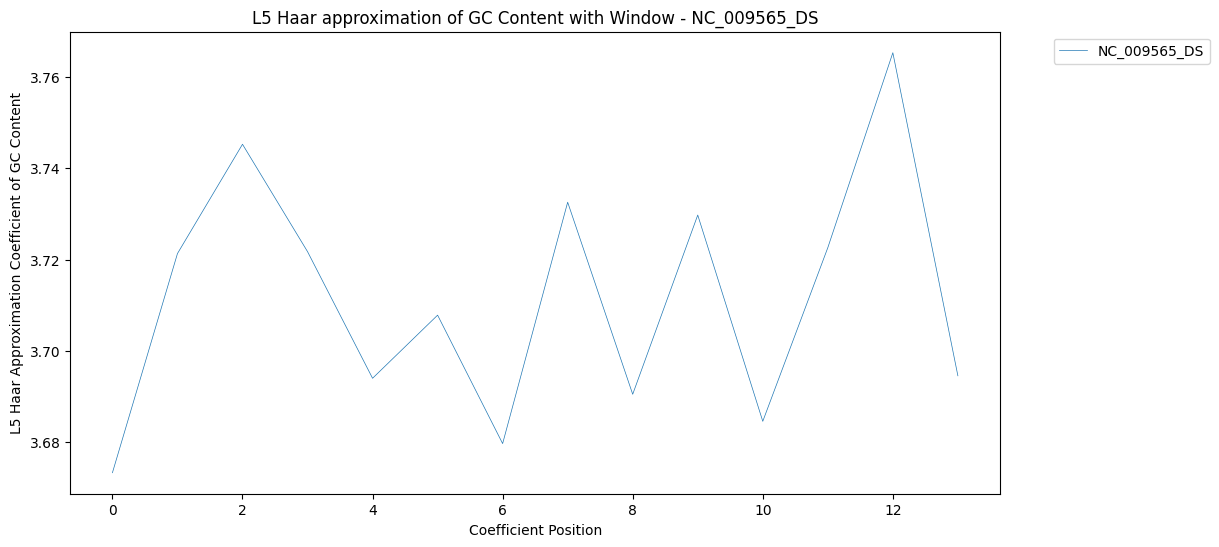

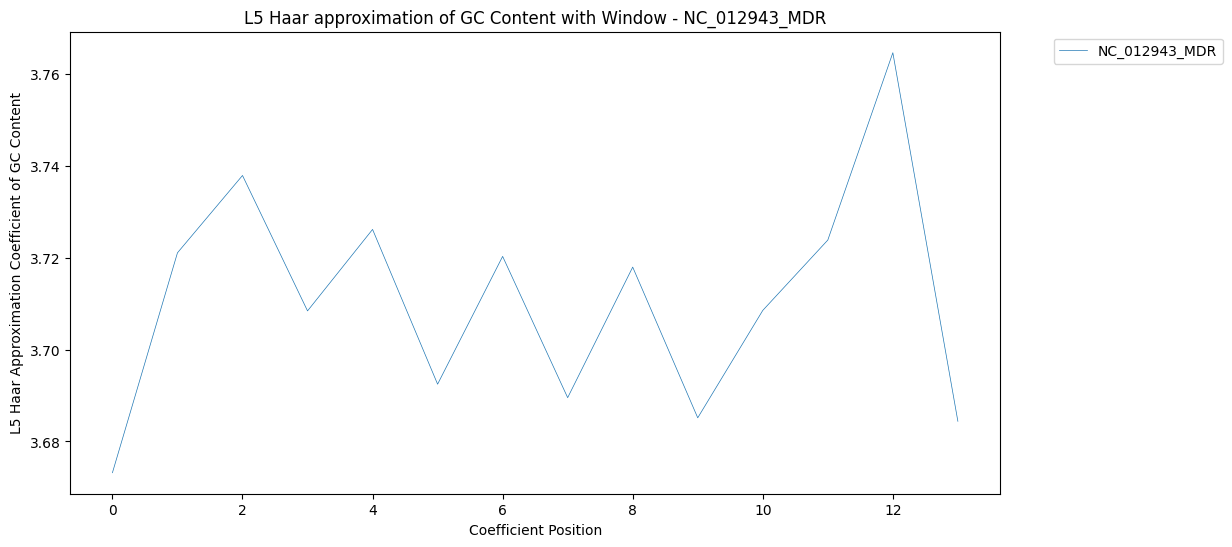

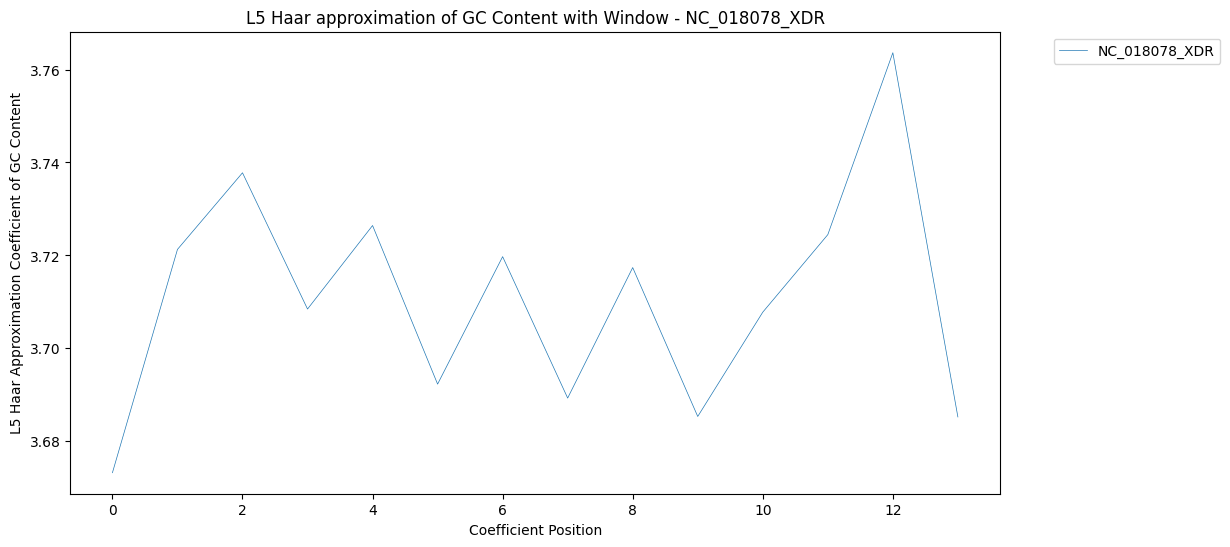

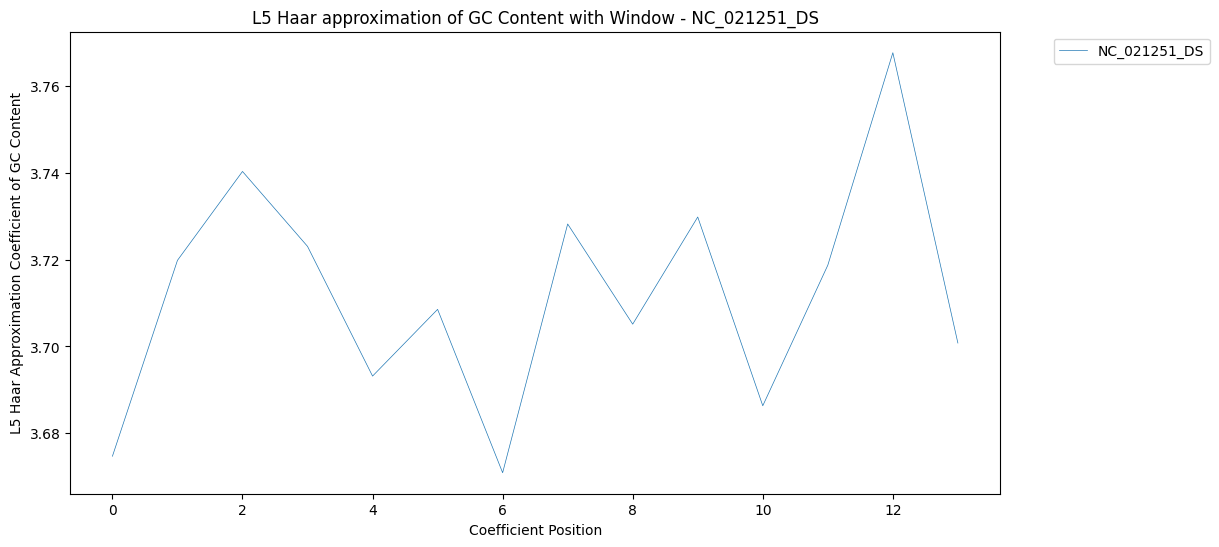

In [187]:
# Apply Haar wavelet transformation to the GC content of each row
final_df['Haar_Approximation_GC_Encoded'] = final_df['GC_Content_Windowed'].apply(lambda x: pywt.wavedec(x, 'haar', level=5)[0])

# Plot the approximation coefficients for each row separately
for index, row in final_df.iterrows():
    plt.figure(figsize=(12, 6))  # Create a new figure for each row
    label_value = row['Label'] 
    plt.plot([i for i in range(len(row['Haar_Approximation_GC_Encoded']))], row['Haar_Approximation_GC_Encoded'], label=label_value, linewidth=0.5)

    plt.title(f'L5 Haar approximation of GC Content with Window - {label_value}')
    plt.xlabel('Coefficient Position')
    plt.ylabel('L5 Haar Approximation Coefficient of GC Content')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


Con esta técnica solo se caracteriza las  multidrug-resistant  (MDR TB) en comparación a DS que son sensibles a los antibioticos y DR que son las resistente a algún antibiotico

In [5]:
final_df.head()

NCBI_title  \
0  CP001641.1 Mycobacterium tuberculosis CCDC5079...   
1  CP001642.1 Mycobacterium tuberculosis CCDC5180...   
2  CP001658.1 Mycobacterium tuberculosis KZN 1435...   
3  CP001664.1 Mycobacterium tuberculosis str. Haa...   
4  CP002884.1 Mycobacterium tuberculosis CCDC5079...   

                                            Sequence  Letter_Count  \
0  TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4396712   
1  TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4403881   
2  ATTTGTGGATAGCCATGTGGACAGTTCACCTGCCCACAACAACGGT...       4396150   
3  TTTGTGGATAGCCATGTGGACAGTTCACCTGCCCACAACAACGGTT...       4406124   
4  TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4412225   

            Label   GC_mean                                         GC_Encoded  
0     CP001641_DS  0.656120  [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, ...  
1     CP001642_DR  0.655938  [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, ...  
2  CP001658.1_MDR  0.656141  [-1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1,...  
3     CP001664_DR  0.656301  [1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, ...  
4     CP002884_DS  0.656129  [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, ...

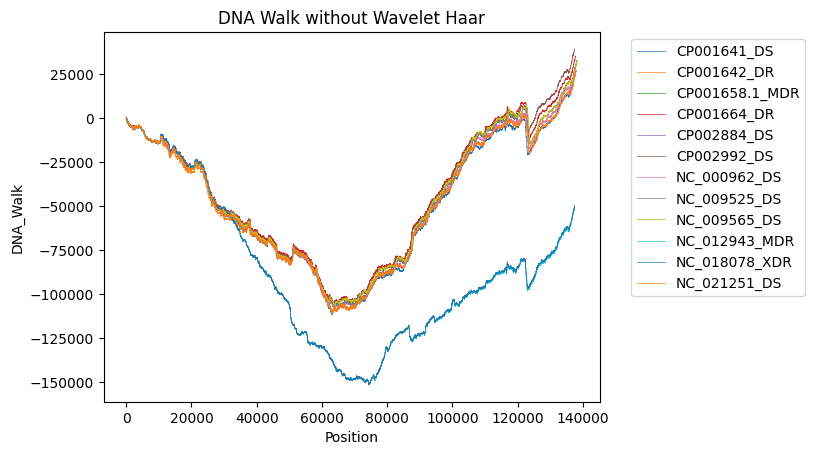

In [7]:
# Add a new column 'DNA_Walk' to the DataFrame
final_df['DNA_Walk'] = final_df['GC_Encoded'].apply(lambda x: np.cumsum(x))

final_df['DNA_Walk'] = final_df['GC_Encoded']..apply(lambda x: pywt.wavedec(x, 'haar', level=5)[0])
# Plot the DNA_Walk for each row
for index, row in final_df.iterrows():
    position_values = range(len(row['DNA_Walk']))
    plt.plot(position_values, row['DNA_Walk'], label=row['Label'],linewidth=0.5 )

plt.title('DNA Walk without Wavelet Haar')
plt.xlabel('Position')
plt.ylabel('DNA_Walk')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

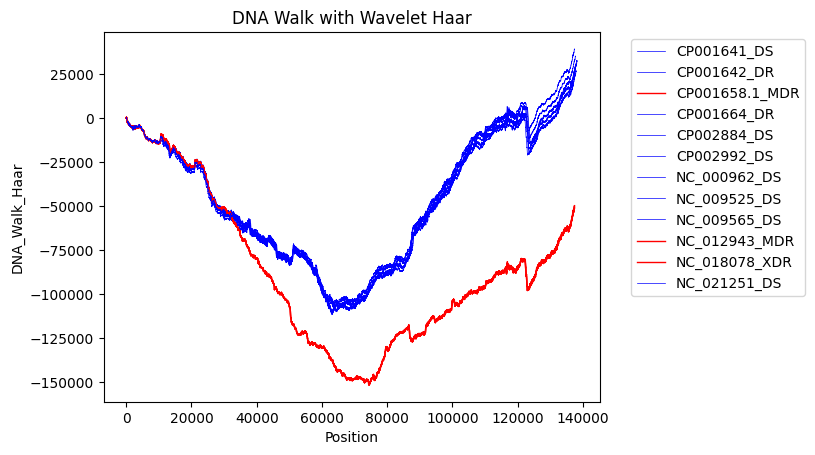

In [21]:
# Add a new column 'DNA_Walk' to the DataFrame
final_df['DNA_Walk'] = final_df['GC_Encoded'].apply(lambda x: np.cumsum(x))

# Apply Haar wavelet transformation to the DNA_Walk of each row
final_df['DNA_Walk_Haar'] = final_df['DNA_Walk'].apply(lambda x: pywt.wavedec(x, 'haar', level=5)[0])

# Plot the DNA_Walk for each row
for index, row in final_df.iterrows():
    position_values = range(len(row['DNA_Walk_Haar']))
    label_value = row['Label']
    
    # Check if the current row is one of the specified indices
    if index in [2, 9, 10]:
        plt.plot(position_values, row['DNA_Walk_Haar'], label=label_value, linewidth=1, color='red')
    else:
        plt.plot(position_values, row['DNA_Walk_Haar'], label=label_value, linewidth=0.5, color='blue')

plt.title('DNA Walk with Wavelet Haar level 5')
plt.xlabel('Position')
plt.ylabel('DNA Walk ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


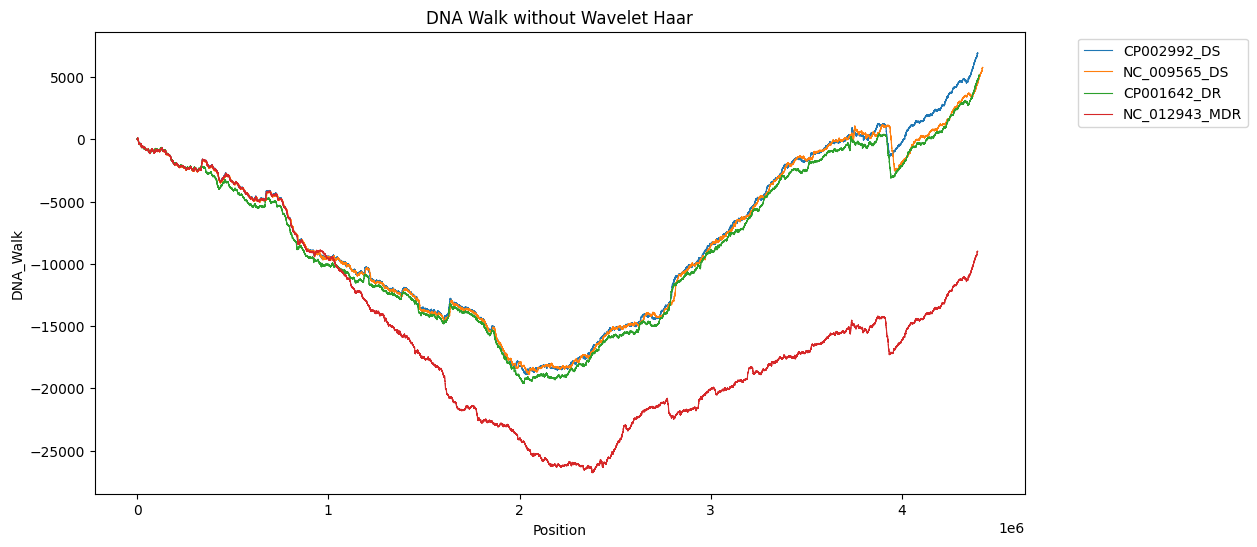

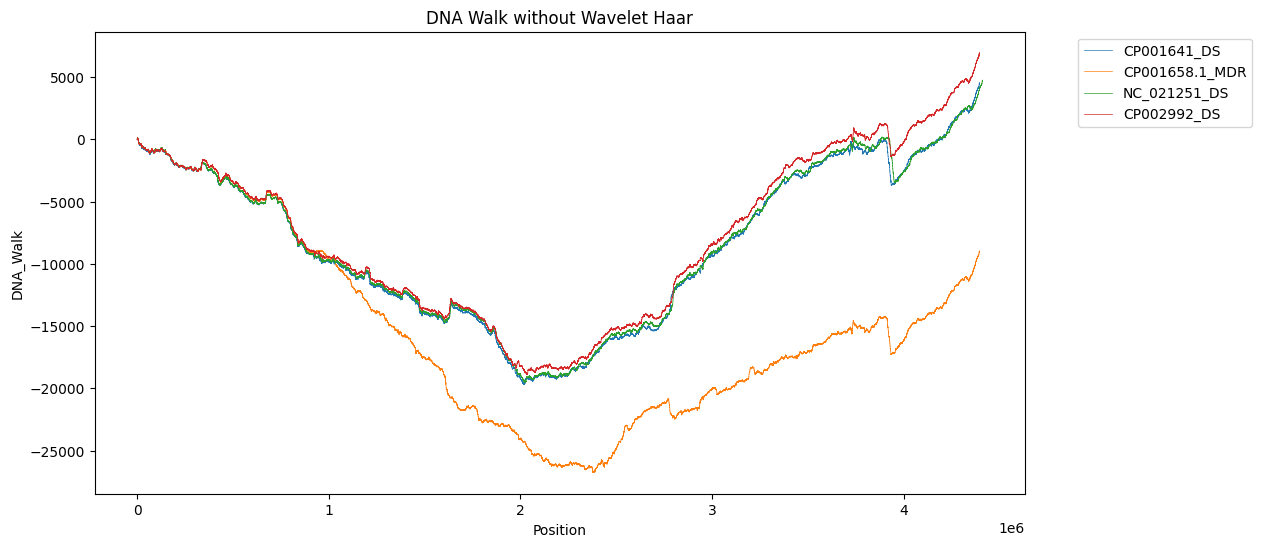

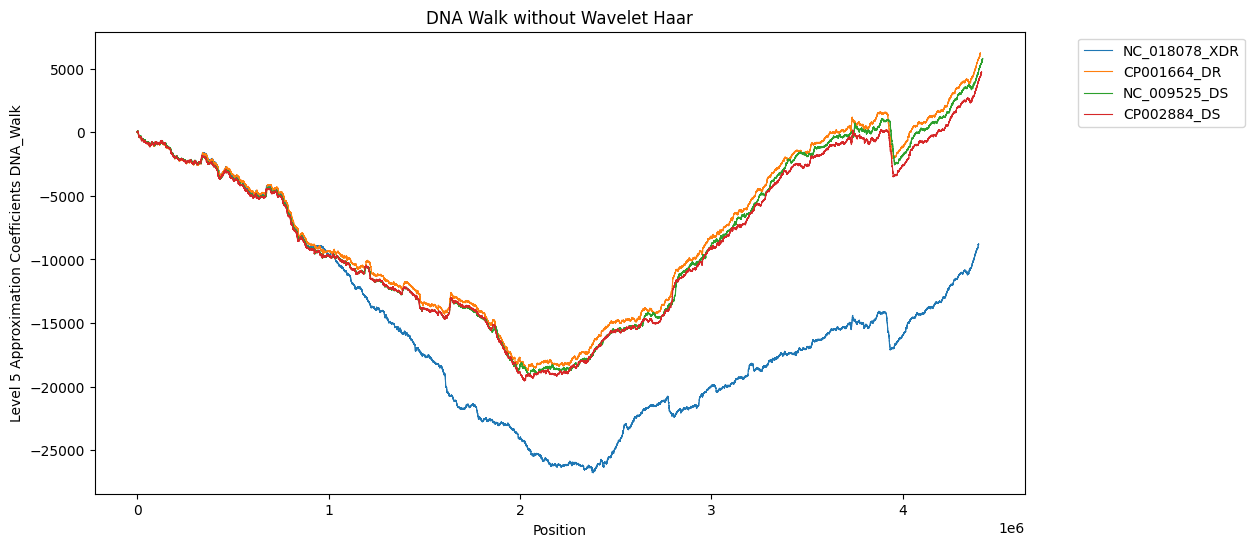

In [22]:
group1_indices = [5,8,1,9] 
group2_indices = [0,2,11,5] 
group3_indices =[10,3,7,4]




plt.figure(figsize=(12, 6))
for index in group1_indices:
    label_value = final_df.loc[index, 'Label']
    plt.plot([i for i in range(len(final_df.loc[index, 'DNA_Walk']))],
             final_df.loc[index, 'DNA_Walk'],
             label=label_value, linewidth=0.8)

plt.title('DNA Walk without Wavelet Haar')
plt.xlabel('Position')
plt.ylabel('DNA_Walk')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the approximation coefficients for the second group
plt.figure(figsize=(12, 6))
for index in group2_indices:
    label_value = final_df.loc[index, 'Label']
    plt.plot([i for i in range(len(final_df.loc[index, 'DNA_Walk']))],
             final_df.loc[index, 'DNA_Walk'],
             label=label_value, linewidth=0.5)

plt.title('DNA Walk without Wavelet Haar')
plt.xlabel('Position')
plt.ylabel('DNA_Walk')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
for index in group3_indices:
    label_value = final_df.loc[index, 'Label']
    plt.plot([i for i in range(len(final_df.loc[index, 'DNA_Walk']))],
             final_df.loc[index, 'DNA_Walk'],
             label=label_value, linewidth=0.8)

plt.title('DNA Walk without Wavelet Haar')
plt.xlabel('Position')
plt.ylabel('Level 5 Approximation Coefficients DNA_Walk')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [136]:
len(final_df['DNA_Walk'][0]) #4396712

4396712

In [20]:
final_df.head()

NCBI_title  \
0  CP001641.1 Mycobacterium tuberculosis CCDC5079...   
1  CP001642.1 Mycobacterium tuberculosis CCDC5180...   
2  CP001658.1 Mycobacterium tuberculosis KZN 1435...   
3  CP001664.1 Mycobacterium tuberculosis str. Haa...   
4  CP002884.1 Mycobacterium tuberculosis CCDC5079...   

                                            Sequence  Letter_Count  \
0  TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4396712   
1  TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4403881   
2  ATTTGTGGATAGCCATGTGGACAGTTCACCTGCCCACAACAACGGT...       4396150   
3  TTTGTGGATAGCCATGTGGACAGTTCACCTGCCCACAACAACGGTT...       4406124   
4  TTGACCGATGACCCCGGTTCAGGCTTCACCACAGTGTGGAACGCGG...       4412225   

            Label   GC_mean  \
0     CP001641_DS  0.656120   
1     CP001642_DR  0.655938   
2  CP001658.1_MDR  0.656141   
3     CP001664_DR  0.656301   
4     CP002884_DS  0.656129   

                                          GC_Encoded  \
0  [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, ...   
1  [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, ...   
2  [-1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1,...   
3  [1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, ...   
4  [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, ...   

                                            DNA_Walk  \
0  [12.727922061357859, 19.091883092036788, 12.02...   
1  [12.727922061357859, 19.091883092036788, 12.02...   
2  [-4.2426406871192865, 5.303300858899108, -27.9...   
3  [1.7677669529663693, 10.960155108391492, -24.7...   
4  [12.727922061357859, 19.091883092036788, 12.02...   

                                   haar_5_GC_Encoded  \
0  [[1.0606601717798214, -0.35355339059327384, -0...   
1  [[1.0606601717798214, -0.35355339059327384, -0...   
2  [[0.0, 0.0, -2.121320343559643, 0.707106781186...   
3  [[0.35355339059327384, 0.0, -2.474873734152917...   
4  [[1.0606601717798214, -0.35355339059327384, -0...   

                                 GC_Content_Windowed  \
0  [0.613, 0.6131, 0.6477, 0.6584, 0.6386, 0.6526...   
1  [0.6122, 0.6123, 0.6431, 0.6563, 0.6395, 0.655...   
2  [0.6113, 0.6114, 0.6445, 0.6575, 0.6407, 0.652...   
3  [0.6115, 0.6115, 0.6445, 0.6576, 0.6404, 0.652...   
4  [0.6121, 0.6122, 0.6431, 0.6563, 0.6396, 0.655...   

                       Haar_Approximation_GC_Encoded  
0  [3.67532891657332, 3.7211140806551484, 3.74087...  
1  [3.674586454453074, 3.7158638128048382, 3.7387...  
2  [3.6731899185602304, 3.72104336997703, 3.73787...  
3  [3.6733666952555266, 3.71992967679666, 3.74582...  
4  [3.674692520470251, 3.719841288449012, 3.74032...

In [149]:
len(final_df['Haar_Approximation_DNA_Walk'][0]) #4396712

2198356

In [195]:
csv_path = "C:/Users/Miranda Córdova/Desktop/deep learning/tuberculosis_df.csv"

# Export the DataFrame to a CSV file
final_df.to_csv(csv_path, index=False)
#7:43